# Импорт библиотек


In [1]:
pip install pytimeparse

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic_2d
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import datetime
from sklearn.cluster import KMeans
from sklearn import linear_model, model_selection, metrics
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, TSNE
from sklearn.metrics import pairwise_distances
from sklearn.random_projection import SparseRandomProjection
from itertools import product
import warnings
from joblib import dump, load
import warnings
warnings.filterwarnings("ignore")
import folium
from pandas.tseries.holiday import USFederalHolidayCalendar
import csv
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from scipy.spatial import distance
from pytimeparse.timeparse import timeparse

drive.mount('/final_project/')

%cd "/final_project/MyDrive/final_project"
%ls

# Функции

In [3]:
def preproccessing_and_aggregation_data(file, REGIONS, NY_LOCATION):


  data = pd.read_csv(file, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

  # удаляем поездки с нулевой длительностью
  data = data[data['tpep_dropoff_datetime'] != data['tpep_pickup_datetime']]

  # удаляем поездки с нулевым количеством пассажиров
  data = data[data.passenger_count != 0]

  # удаляем поездки с нулевым расстояние поездки
  data = data[data.trip_distance != 0]

  # удаляем поездки с координатами не в Нью-Йорке
  data = data[((data.pickup_longitude > NY_LOCATION[0]) & (data.pickup_longitude < NY_LOCATION[1])) & ((data.pickup_latitude > NY_LOCATION[2]) & (data.pickup_latitude < NY_LOCATION[3]))]

  # добавляем столбец с часом
  data['tpep_pickup_hour'] = data.tpep_pickup_datetime.map(lambda x: x.floor(freq='h'))

  # определяем номер региона для каждого вызова такси (скопировал из обсуждений)
  statistic = binned_statistic_2d(data['pickup_longitude'].values, 
                                  data['pickup_latitude'].values, 
                                  data['VendorID'], 
                                  statistic='count', 
                                  bins=[REGIONS['west'].append(REGIONS['east']).unique(), 
                                        REGIONS['south'].append(REGIONS['north']).unique()], 
                                  expand_binnumbers=True)
                                    
  data['region'] = (statistic[3][0] - 1) * 50 + statistic[3][1]

  # создаем сводную таблицу по сумме количества поездок, в которой в колонках номера регионов, а в индексе час начала поездок 
  agg_table = pd.pivot_table(data, values='VendorID', index='tpep_pickup_hour', columns='region', aggfunc='count')
  data = None
  return agg_table

def load_data(AGG_FILES, date_before, date_after):
  data = pd.concat([pd.read_csv(file, sep=';', parse_dates=['tpep_pickup_hour']) for file in AGG_FILES])
  data.set_index('tpep_pickup_hour', inplace=True)
  data = data[COLUMNS_FROM_2_WEEK]
  data = data[date_after <= data.index]
  data = data[data.index <= date_before]
  data.fillna(value=0, inplace=True)
  return data



def get_regions_from_second_week():
  data = pd.read_csv('agg_yellow_tripdata_2016-05.csv', sep=';')
  data.set_index('tpep_pickup_hour', inplace=True)
  cols = (data.sum(axis=0) / len(data)) >= 5
  cols = cols.reset_index()
  return cols[cols[0] == True]['index'].values

def my_style_function(x):
    color = ''
    if x['properties']['cluster'] == 0:
        color = 'green'
    elif x['properties']['cluster'] == 1:
        color = 'orange'
    elif x['properties']['cluster'] == 2:
        color = 'blue'
    elif x['properties']['cluster'] == 3:
        color = 'green'
    elif x['properties']['cluster'] == 4:
        color = 'yellow'
    return {'fillColor': color, 'stroke': True, 'weight': 0.5, 'fillOpacity':0.7}


def add_features(data, k, holidays):
    data['const'] = 1
    data['lin'] = np.arange(1, data.shape[0]+1)
    data['is_holiday'] = [x in holidays for x in data.index.floor('d')]
    features_columns = ['const', 'lin', 'is_holiday']
    features_columns += month_features(data)
    features_columns += weekday_features(data)
    features_columns += hour_features(data)
    for i in range(1, k+1):
        week_sin_col = f'week_sin_{i}'
        week_cos_col = f'week_cos_{i}'
        data[week_sin_col] = np.sin(np.array(data['lin'] * 2 * np.pi * i / 168))
        data[week_cos_col] = np.cos(np.array(data['lin'] * 2 * np.pi * i / 168))
        features_columns += [week_sin_col, week_cos_col]

    data.replace(True, 1, inplace=True)
    data.replace(False, 0, inplace=True)
    return features_columns

def get_reg_pred(data, features_columns):
    train_data = np.array(data[features_columns])
    train_labels = np.array(data['trips'])
    
    model = ElasticNet(random_state=42)
    model.fit(train_data, train_labels)
    
    preds = model.predict(data[features_columns])
    
    data['reg_pred'] = preds
    data['reg_resid'] = data['trips'] - preds
    
    return preds

def month_features(data):
  features_columns = []
  for x in range(1, 13):
    col_name = f'month{x}'
    data[col_name] = [data.index.month == x][0]
    features_columns.append(col_name)
  
  data.replace(True, 1, inplace=True)
  data.replace(False, 0, inplace=True)
  return features_columns

def hour_features(data):
  features_columns = []
  for x in range(0, 24):
    col_name = f'hour{x}'
    data[col_name] = [data.index.hour == x][0]
    features_columns.append(col_name)
  data.replace(True, 1, inplace=True)
  data.replace(False, 0, inplace=True)
  return features_columns

def weekday_features(data):
  features_columns = []
  for x in range(0, 7):
    col_name = f'weekday{x}'
    data[col_name] = [data.index.weekday == x][0]
    features_columns.append(col_name)
  data.replace(True, 1, inplace=True)
  data.replace(False, 0, inplace=True)
  return features_columns


def load_data_cluster(cluster=0, 
                      date_after=datetime.datetime(2015, 12, 1, 0), 
                      date_before=datetime.datetime(2016, 5, 31, 23)) :
  data_cluster = pd.DataFrame(load_data(AGG_FILES, date_before, date_after)[str(closest_regions[cluster][0])])
  data_cluster.columns = ['trips']
  features_columns = add_features(data_cluster, K, HOLIDAYS)
  reg_pred = get_reg_pred(data_cluster, features_columns)
  return data_cluster

def plot_linear_reg(data_cluster):
  plt.figure(figsize=(20, 5))
  data_cluster['trips'].rolling(24).mean().plot(legend=True, title=f'Фактическое количество + прогноз линейной регрессии при K={K}')
  data_cluster['reg_pred'].rolling(24).mean().plot(legend=True)
  plt.show()

  plt.figure(figsize=(20, 5))
  data_cluster.reg_resid.rolling(24).mean().plot(title='Остатки', legend=True)
  plt.show()

def plot_decompose(data_cluster, reg_resid):
  result = sm.tsa.seasonal_decompose(data_cluster[reg_resid].dropna(), freq=24)
  fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(25,10))
  axes[0].plot(result.observed)
  axes[0].set(ylabel='Observed')
  axes[1].plot(result.trend)
  axes[1].set(ylabel='trend')
  axes[2].plot(result.seasonal)
  axes[2].set(ylabel='seasonal')
  axes[3].plot(result.resid)  
  axes[3].set(ylabel='resid') 
  print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_cluster.trips)[1])
  plt.show()

def plot_acf_pacf(data_cluster):
  print('Строим полную и частичную автокорреляцию')
  plt.figure(figsize=(20,10))
  ax = plt.subplot(211)
  sm.graphics.tsa.plot_acf(data_cluster.reg_resid_diff.dropna().values.squeeze(), lags=168, ax=ax)
  ax = plt.subplot(212)
  sm.graphics.tsa.plot_pacf(data_cluster.reg_resid_diff.dropna().values.squeeze(), lags=168, ax=ax)
  plt.show()



def select_best_arima(data, params, d, D):
  results = []
  best_aic = float("inf")
  warnings.filterwarnings('ignore')
  i=0
  for param in params:
      print(i, '-', param, '...', datetime.datetime.now(), '...')
      i+=1
      #try except нужен, потому что на некоторых наборах параметров модель не обучается
      try:
          model=sm.tsa.statespace.SARIMAX(data.reg_resid, order=(param[0], d, param[1]), 
                                          seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1, maxiter=14)
      
      #выводим параметры, на которых модель не обучается и переходим к следующему набору
      except ValueError:
          print('wrong parameters:', param)
          continue
      aic = model.aic
      #сохраняем лучшую модель, aic, параметры
      if aic < best_aic:
          best_model = model
          best_aic = aic
          best_param = param
      results.append([param, model.aic])
      
  warnings.filterwarnings('default')
  return (best_model, results)


def new_preproccessing_and_aggregation_data(file, REGIONS, NY_LOCATION):
    data = pd.read_csv(file, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
    # удаляем поездки с нулевой длительностью
    data = data[data['tpep_dropoff_datetime'] != data['tpep_pickup_datetime']]

    # удаляем поездки с нулевым количеством пассажиров
    data = data[data.passenger_count != 0]

    # удаляем поездки с нулевым расстояние поездки
    data = data[data.trip_distance != 0]

    # удаляем поездки с координатами не в Нью-Йорке
    data = data[((data.pickup_longitude > NY_LOCATION[0]) & (data.pickup_longitude < NY_LOCATION[1])) & ((data.pickup_latitude > NY_LOCATION[2]) & (data.pickup_latitude < NY_LOCATION[3]))]

    # добавляем столбец с часом
    data['tpep_pickup_hour'] = data.tpep_pickup_datetime.apply(lambda x: x.floor(freq='h'))

    # определяем номер региона для каждого вызова такси (скопировал из обсуждений)
    statistic = binned_statistic_2d(data['pickup_longitude'].values, 
                                    data['pickup_latitude'].values, 
                                    data['VendorID'], 
                                    statistic='count', 
                                    bins=[REGIONS['west'].append(REGIONS['east']).unique(), 
                                          REGIONS['south'].append(REGIONS['north']).unique()], 
                                    expand_binnumbers=True)
                                      
    data['region'] = (statistic[3][0] - 1) * 50 + statistic[3][1]

    # определяем номер региона для окончания поездок
    statistic = binned_statistic_2d(data['dropoff_longitude'].values, 
                                    data['dropoff_latitude'].values, 
                                    data['VendorID'], 
                                    statistic='count', 
                                    bins=[REGIONS['west'].append(REGIONS['east']).unique(), 
                                          REGIONS['south'].append(REGIONS['north']).unique()], 
                                    expand_binnumbers=True)
                                      
    data['region_dropoff'] = (statistic[3][0] - 1) * 50 + statistic[3][1]

    # определяем продолжительность поездки
    data['duration_of_trip'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']

    # делаем dummy кодирование столбцов с категориальными данными
    data = pd.get_dummies(data, columns=['RateCodeID'], prefix='RateCodeID')
    data = pd.get_dummies(data, columns=['VendorID'], prefix='VendorID')
    data = pd.get_dummies(data, columns=['payment_type'], prefix='payment_type')
    # создаем сводную таблицу по всем интересующим признакам
    agg_table = pd.pivot_table(data, 
                              values=['passenger_count', 
                                      'trip_distance', 
                                      'fare_amount', 
                                      'duration_of_trip', 
                                      'RateCodeID_1', 
                                      'RateCodeID_2',
                                      'RateCodeID_3', 
                                      'RateCodeID_4', 
                                      'RateCodeID_5', 
                                      'RateCodeID_6',
                                      'RateCodeID_99', 
                                      'VendorID_1', 
                                      'VendorID_2', 
                                      'payment_type_1',
                                      'payment_type_2',
                                      'payment_type_3', 
                                      'payment_type_4', 
                                      'payment_type_5'], 
                              index=['tpep_pickup_hour', 'region'],  
                              aggfunc={'region': 'count', 
                                        'passenger_count': 'sum', 
                                        'trip_distance': 'sum', 
                                        'fare_amount': 'sum', 
                                        'duration_of_trip': 'sum', 
                                        'RateCodeID_1': 'sum', 
                                        'RateCodeID_2': 'sum', 
                                        'RateCodeID_3': 'sum', 
                                        'RateCodeID_4': 'sum', 
                                        'RateCodeID_5': 'sum', 
                                        'RateCodeID_6': 'sum', 
                                        'RateCodeID_99': 'sum', 
                                        'VendorID_1': 'sum', 
                                        'VendorID_2': 'sum', 
                                        'payment_type_1': 'sum',
                                        'payment_type_2': 'sum', 
                                        'payment_type_3': 'sum', 
                                        'payment_type_4': 'sum', 
                                        'payment_type_5': 'sum'
                                        })

    # добавляем столбец с количеством поездок, которые заканчиваются в этом регионе/ячейке
    agg_table.rename({'region': 'count_trips'}, inplace=True, axis=1)
    temp = pd.pivot_table(data, values=['region'], index=['tpep_pickup_hour', 'region_dropoff'],  aggfunc='count')
    temp.index.names = ['tpep_pickup_hour', 'region']
    temp.columns = ['trips_dropoff']
    agg_table = agg_table.join(temp)
    agg_table.reset_index(inplace=True)
    # сохраняем сформированный файл
    agg_table.to_csv('new_agg_'+file, sep=';', index=False)
    data = None
    agg_table = None
    temp = None
    return None


def new_read_and_aggregation_data():
    for file in FILES:
        data = pd.read_csv(file, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
        # удаляем поездки с нулевой длительностью
        data = data[data['tpep_dropoff_datetime'] != data['tpep_pickup_datetime']]

        # удаляем поездки с нулевым количеством пассажиров
        data = data[data.passenger_count != 0]

        # удаляем поездки с нулевым расстояние поездки
        data = data[data.trip_distance != 0]

        # удаляем поездки с координатами не в Нью-Йорке
        data = data[((data.pickup_longitude > NY_LOCATION[0]) & (data.pickup_longitude < NY_LOCATION[1])) & ((data.pickup_latitude > NY_LOCATION[2]) & (data.pickup_latitude < NY_LOCATION[3]))]

        # добавляем столбец с часом
        data['tpep_pickup_hour'] = data.tpep_pickup_datetime.apply(lambda x: x.floor(freq='h'))

        # определяем номер региона для каждого вызова такси (скопировал из обсуждений)
        statistic = binned_statistic_2d(data['pickup_longitude'].values, 
                                        data['pickup_latitude'].values, 
                                        data['VendorID'], 
                                        statistic='count', 
                                        bins=[REGIONS['west'].append(REGIONS['east']).unique(), 
                                              REGIONS['south'].append(REGIONS['north']).unique()], 
                                        expand_binnumbers=True)
                                          
        data['region'] = (statistic[3][0] - 1) * 50 + statistic[3][1]

        # определяем номер региона для окончания поездок
        statistic = binned_statistic_2d(data['dropoff_longitude'].values, 
                                        data['dropoff_latitude'].values, 
                                        data['VendorID'], 
                                        statistic='count', 
                                        bins=[REGIONS['west'].append(REGIONS['east']).unique(), 
                                              REGIONS['south'].append(REGIONS['north']).unique()], 
                                        expand_binnumbers=True)
                                          
        data['region_dropoff'] = (statistic[3][0] - 1) * 50 + statistic[3][1]

        # определяем продолжительность поездки
        data['duration_of_trip'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']

        # делаем dummy кодирование столбцов с категориальными данными
        data = pd.get_dummies(data, columns=['RatecodeID'], prefix='RateCodeID')
        data = pd.get_dummies(data, columns=['VendorID'], prefix='VendorID')
        data = pd.get_dummies(data, columns=['payment_type'], prefix='payment_type')
        # создаем сводную таблицу по всем интересующим признакам
        dict1 = {i : 'sum' for i in list(filter(lambda x: x != None, [x if ('Rate' in x) else None for x in data.columns]))}
        dict2 = {i : 'sum' for i in list(filter(lambda x: x != None, [x if ('Vendor' in x) else None for x in data.columns]))}
        dict3 = {i : 'sum' for i in list(filter(lambda x: x != None, [x if ('payment_type' in x) else None for x in data.columns]))}
        dict4 = {'region': 'count', 'passenger_count': 'sum', 'trip_distance': 'sum', 'fare_amount': 'sum', 'duration_of_trip': 'sum'} 
        aggfunc = {**dict1, **dict2, **dict3, **dict4}
        values = ['passenger_count', 'trip_distance', 'fare_amount', 'duration_of_trip', 'RateCodeID_1', 'RateCodeID_2','RateCodeID_3', 'RateCodeID_4', 'RateCodeID_5', 'RateCodeID_6','RateCodeID_99', 'VendorID_1', 'VendorID_2', 'payment_type_1','payment_type_2','payment_type_3', 'payment_type_4', 'payment_type_5']
        agg_table = pd.pivot_table(data, values=values,
                                  index=['tpep_pickup_hour', 'region'],  
                                  aggfunc=aggfunc)

        # добавляем столбец с количеством поездок, которые заканчиваются в этом регионе/ячейке
        agg_table.rename({'region': 'count_trips'}, inplace=True, axis=1)
        temp = pd.pivot_table(data, values=['region'], index=['tpep_pickup_hour', 'region_dropoff'],  aggfunc='count')
        temp.index.names = ['tpep_pickup_hour', 'region']
        temp.columns = ['trips_dropoff']
        agg_table = agg_table.join(temp)
        agg_table.reset_index(inplace=True)
        # сохраняем сформированный файл
        agg_table.to_csv('new_agg_'+file, sep=';', index=False)
        data = None
        agg_table = None
        temp = None


def train_randomforest_model():
    # создаем пустую таблицу
    data_for_reg = pd.DataFrame(columns=['tpep_pickup_hour'])

    for region_num in COLUMNS_FROM_2_WEEK:
        data_temp = data[data.region == int(region_num)]
        # добавляем столбцы с количеством вызовов такси на 1-6 часов вперед - целевая переменная
        for i in range(1, 7):
          data_temp[f'Y+{i}'] = data_temp.count_trips.shift(-i)

        # добавляем столбцы с количеством вызовов такси на 1-23 часов назад
        for i in range(1, 24):
          data_temp[f'trips-{i}'] = data_temp.count_trips.shift(i)

        # добавляем столбцы с количеством вызовов такси на 24, 48, 168 часов назад
        data_temp['trips-24'] = data_temp.count_trips.shift(24)
        data_temp['trips-48'] = data_temp.count_trips.shift(48)
        data_temp['trips-72'] = data_temp.count_trips.shift(72)
        data_temp['trips-168'] = data_temp.count_trips.shift(168)
        
        # добавляем столбец с накопительным количеством поездок за предыдущие полдня
        data_temp['sum_last_12_hours'] = data_temp.count_trips.rolling(12).sum()
        data_temp['sum_last_24_hours'] = data_temp.count_trips.rolling(24).sum()
        data_temp['sum_last_168_hours'] = data_temp.count_trips.rolling(168).sum()

        # добавляем константы 
        data_temp['const'] = 1
        data_temp['lin'] = np.arange(1, data_temp.shape[0]+1)

        k=10
        # добавляем синусы и косинусы
        for i in range(1, k+1):
              week_sin_col = f'week_sin_{i}'
              week_cos_col = f'week_cos_{i}'
              data_temp[week_sin_col] = np.sin(np.array(data_temp['lin'] * 2 * np.pi * i / 168))
              data_temp[week_cos_col] = np.cos(np.array(data_temp['lin'] * 2 * np.pi * i / 168))

        # добавляем временный dataframe в основной
        data_for_reg = data_for_reg.append(data_temp)
        del data_temp
    # добавляем признак выходного дня
    data_for_reg['is_holiday'] = [x.floor('d') in HOLIDAYS for x in data_for_reg.tpep_pickup_hour]
    data_for_reg.set_index('tpep_pickup_hour', inplace=True)

    # Добавляем признак месяца
    for x in range(1, 13):
      col_name = f'month_{x}'
      data_for_reg[col_name] = [data_for_reg.index.month == x][0]

    # Добавляем признак года
    for x in [2015, 2016]:
      col_name = f'year_{x}'
      data_for_reg[col_name] = [data_for_reg.index.year == x][0]

    # добавляем признак часа
    for x in range(0, 24):
      col_name = f'hour_{x}'
      data_for_reg[col_name] = [data_for_reg.index.hour == x][0]

    # добавляем признак дня недели
    for x in range(0, 7):
      col_name = f'weekday_{x}'
      data_for_reg[col_name] = [data_for_reg.index.weekday == x][0]
    data_for_reg.reset_index(inplace=True)

    # Добавляем номер кластера
    data_for_reg['region_num'] = data_for_reg['region'].astype(np.int64)
    data_for_reg = data_for_reg.merge(regions_with_cluster, how='left', left_on='region', right_on='region') # объединяем с таблицей с номерами кластеров
    #data_for_reg = data_for_reg.drop(['region', 'west', 'east', 'south', 'north'], axis=1) # удаляем столбцы правой таблицы

    # 
    data_for_reg.replace(True, 1, inplace=True)
    data_for_reg.replace(False, 0, inplace=True)
    data_for_reg.fillna(0, inplace=True)
    data_for_reg = pd.get_dummies(data_for_reg, columns=['region_num'], prefix='region_num')
    data_for_reg = pd.get_dummies(data_for_reg, columns=['cluster'], prefix='cluster')

    #del X_train, X_test, Y_train, Y_test, reg

    # дата вызовов такси до апреля включительно
    X_train = data_for_reg[data_for_reg['tpep_pickup_hour'] <= END_APRIL]
    Y_train = data_for_reg[data_for_reg['tpep_pickup_hour'] <= END_APRIL][['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6']]
    X_train_region = X_train.region
    X_train_time = X_train.tpep_pickup_hour
    X_train = X_train[OLDFEATURES+RATECODEIDCOLUMNS+VENDORIDCOLUMNS+PAYMENTTYPECOLUMNS+OTHERNEWFEATURECOLUMNS]

    # дата вызовов такси в июне
    Y_june = data_for_reg[(data_for_reg['tpep_pickup_hour'] >= END_MAY) & (data_for_reg['tpep_pickup_hour'] <= datetime.datetime(2016, 6, 30, 17))][['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6']]
    X_june = data_for_reg[(data_for_reg['tpep_pickup_hour'] >= END_MAY) & (data_for_reg['tpep_pickup_hour'] <= datetime.datetime(2016, 6, 30, 17))]
    X_june_region = X_june.region
    X_june_time = X_june.tpep_pickup_hour
    X_june = X_june[OLDFEATURES+RATECODEIDCOLUMNS+VENDORIDCOLUMNS+PAYMENTTYPECOLUMNS+OTHERNEWFEATURECOLUMNS]

    ERR = []
    X_test = X_june.copy()
    for col in Y_june.columns: # цикл по Y+1 ... Y+6
      # обучаем модель
      reg = RandomForestRegressor(random_state=0, verbose=2, n_jobs=-1)
      reg.fit(X_train, Y_train[col])

      # считаем ошибку
      preds = reg.predict(X_test)
      preds = [0 if x < 0 else x for x in preds] # приравниваем отрицательные прогнозы к нулю
      err = sum(abs(Y_june[col] - preds)) / len(Y_june)
      print(f'col {col}, result =', err)
      X_june[f'pred{col}'] = preds
      # добавляем ошибку для подсчета по всем итераци
      dump(preds, f'preds_{col}.joblib')
      ERR.append(err)
    print(sum(ERR) / 6)



### 1 Загрузите обучающие выборки прошлой недели, перечислите используемые в моделях признаки и посчитайте Q

В модели на прошлой неделе использованы следуюище признаки:

- количество поездок от 1,2,3...23 часов назад
- количество поездок 24, 48, 168 часов назад
- синусы и косинусы
- признак выходного дня в USFederalHolidayCalendar
- признак года (0 или 1)
- признак месяца (0 или 1)
- признак дня недели (0 или 1)
- признак часа (0 или 1)
- номер кластера
- количество поездок за предыдущие 12, 24, 168 часов 

 
 Результат:


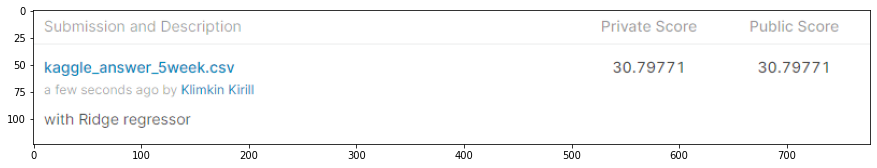

In [35]:
img = plt.imread('answer.png')
plt.figure(figsize=(15,7))
plt.imshow(img)
plt.show()

# 2 Попробуйте добавить признаки. 
Используйте идеи, которые мы предложили, или какие-то свои. Обучайте обновлённые модели на данных до апреля 2016 включительно и считайте качество новых прогнозов на мае. Удаётся ли вам улучшить качество? Не нужно ли увеличить сложность регрессионной модели? Если добавляемый признак не улучшает качество, всё равно оставьте доказательства этому в ноутбуке, чтобы ваши коллеги это видели при проверке. 

### возьмем дополнительно признаки из сырых данных:

duration_of_trip - суммарное время всех поездок за час

trip_distance - суммарная дистацния всех поездок за час

fare_amount - суммарная стоимость поездок за час

passenger_count - суммарное количество пассажиров за час

VendorID_* - количество поездок по каждому провайдеру за час

RateCodeID_* - количество поездок по каждому тарифу за час

payment_type_* - количество поездок по каждому виду оплаты за час

trips_dropoff - количество поездок, заканчивающихся в этой ячейке/регионе за час

count_trips - количество поездок, начинающихся в этой ячейке/регионе за час 


In [4]:
REGIONS = pd.read_csv('regions.csv', sep=';')
NY_LOCATION = [-74.25559, -73.70001, 40.49612, 40.91553]
COLUMNS_FROM_2_WEEK = get_regions_from_second_week()
HOLIDAYS = USFederalHolidayCalendar().holidays(start=datetime.datetime(2015, 1, 1), end=datetime.datetime(2016, 6, 1))
FILES = ['yellow_tripdata_2015-01.csv',
         'yellow_tripdata_2015-02.csv',
         'yellow_tripdata_2015-03.csv',
         'yellow_tripdata_2015-04.csv',
         'yellow_tripdata_2015-05.csv',
         'yellow_tripdata_2015-06.csv',
         'yellow_tripdata_2015-07.csv',
         'yellow_tripdata_2015-08.csv',
         'yellow_tripdata_2015-09.csv',
         'yellow_tripdata_2015-10.csv',
         'yellow_tripdata_2015-11.csv',
         'yellow_tripdata_2015-12.csv',
         'yellow_tripdata_2016-01.csv',
         'yellow_tripdata_2016-02.csv',
         'yellow_tripdata_2016-03.csv',
         'yellow_tripdata_2016-04.csv',
         'yellow_tripdata_2016-05.csv',
         'yellow_tripdata_2016-06.csv']

In [ ]:
file = 'yellow_tripdata_2015-01.csv'
data = pd.read_csv(file, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
# удаляем поездки с нулевой длительностью
data = data[data['tpep_dropoff_datetime'] != data['tpep_pickup_datetime']]

# удаляем поездки с нулевым количеством пассажиров
data = data[data.passenger_count != 0]

# удаляем поездки с нулевым расстояние поездки
data = data[data.trip_distance != 0]

# удаляем поездки с координатами не в Нью-Йорке
data = data[((data.pickup_longitude > NY_LOCATION[0]) & (data.pickup_longitude < NY_LOCATION[1])) & ((data.pickup_latitude > NY_LOCATION[2]) & (data.pickup_latitude < NY_LOCATION[3]))]

# добавляем столбец с часом
data['tpep_pickup_hour'] = data.tpep_pickup_datetime.apply(lambda x: x.floor(freq='h'))

# определяем номер региона для каждого вызова такси (скопировал из обсуждений)
statistic = binned_statistic_2d(data['pickup_longitude'].values, 
                                data['pickup_latitude'].values, 
                                data['VendorID'], 
                                statistic='count', 
                                bins=[REGIONS['west'].append(REGIONS['east']).unique(), 
                                      REGIONS['south'].append(REGIONS['north']).unique()], 
                                expand_binnumbers=True)
                                  
data['region'] = (statistic[3][0] - 1) * 50 + statistic[3][1]

# определяем номер региона для окончания поездок
statistic = binned_statistic_2d(data['dropoff_longitude'].values, 
                                data['dropoff_latitude'].values, 
                                data['VendorID'], 
                                statistic='count', 
                                bins=[REGIONS['west'].append(REGIONS['east']).unique(), 
                                      REGIONS['south'].append(REGIONS['north']).unique()], 
                                expand_binnumbers=True)
                                  
data['region_dropoff'] = (statistic[3][0] - 1) * 50 + statistic[3][1]

# определяем продолжительность поездки
data['duration_of_trip'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']

# делаем dummy кодирование столбцов с категориальными данными
data = pd.get_dummies(data, columns=['RateCodeID'], prefix='RateCodeID')
data = pd.get_dummies(data, columns=['VendorID'], prefix='VendorID')
data = pd.get_dummies(data, columns=['payment_type'], prefix='payment_type')
data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,tpep_pickup_hour,region,region_dropoff,duration_of_trip,RateCodeID_1,RateCodeID_2,RateCodeID_3,RateCodeID_4,RateCodeID_5,RateCodeID_6,RateCodeID_99,VendorID_1,VendorID_2,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,N,-73.974785,40.750618,12.0,1.0,0.5,3.25,0.0,0.3,17.05,2015-01-15 19:00:00,1181,1281,0 days 00:18:03,1,0,0,0,0,0,0,0,1,1,0,0,0,0
1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,N,-73.994415,40.759109,14.5,0.5,0.5,2.00,0.0,0.3,17.80,2015-01-10 20:00:00,1128,1182,0 days 00:19:50,1,0,0,0,0,0,0,1,0,1,0,0,0,0
2,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,N,-73.951820,40.824413,9.5,0.5,0.5,0.00,0.0,0.3,10.80,2015-01-10 20:00:00,1337,1390,0 days 00:10:03,1,0,0,0,0,0,0,1,0,0,1,0,0,0
3,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,N,-74.004326,40.719986,3.5,0.5,0.5,0.00,0.0,0.3,4.80,2015-01-10 20:00:00,1126,1127,0 days 00:01:52,1,0,0,0,0,0,0,1,0,0,1,0,0,0
4,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,N,-74.004181,40.742653,15.0,0.5,0.5,0.00,0.0,0.3,16.30,2015-01-10 20:00:00,1282,1130,0 days 00:19:19,1,0,0,0,0,0,0,1,0,0,1,0,0,0


In [ ]:
# создаем сводную таблицу по всем интересующим признакам
agg_table = pd.pivot_table(data, 
                           values=['passenger_count', 
                                   'trip_distance', 
                                   'fare_amount', 
                                   'duration_of_trip', 
                                   'RateCodeID_1', 
                                   'RateCodeID_2',
                                   'RateCodeID_3', 
                                   'RateCodeID_4', 
                                   'RateCodeID_5', 
                                   'RateCodeID_6',
                                   'RateCodeID_99', 
                                   'VendorID_1', 
                                   'VendorID_2', 
                                   'payment_type_1',
                                   'payment_type_2',
                                   'payment_type_3', 
                                   'payment_type_4', 
                                   'payment_type_5'
                                   ], 
                           index=['tpep_pickup_hour', 'region'],  
                           aggfunc={'region': 'count', 
                                    'passenger_count': 'sum', 
                                    'trip_distance': 'sum', 
                                    'fare_amount': 'sum', 
                                    'duration_of_trip': 'sum', 
                                    'RateCodeID_1': 'sum', 
                                    'RateCodeID_2': 'sum', 
                                    'RateCodeID_3': 'sum', 
                                    'RateCodeID_4': 'sum', 
                                    'RateCodeID_5': 'sum', 
                                    'RateCodeID_6': 'sum', 
                                    'RateCodeID_99': 'sum', 
                                    'VendorID_1': 'sum', 
                                    'VendorID_2': 'sum', 
                                    'payment_type_1': 'sum',
                                    'payment_type_2': 'sum', 
                                    'payment_type_3': 'sum', 
                                    'payment_type_4': 'sum', 
                                    'payment_type_5': 'sum'
                                    })

agg_table.head()

RateCodeID_1  RateCodeID_2  ...  region  trip_distance
tpep_pickup_hour region                              ...                       
2015-01-01       169              1.0             0  ...       1           0.05
                 324              2.0             0  ...       2           4.80
                 935              0.0             0  ...       1           1.10
                 965              1.0             0  ...       1          15.70
                 978              2.0             0  ...       3          10.71

[5 rows x 19 columns]

In [ ]:
# добавляем столбец с количеством поездок, которые заканчиваются в этом регионе/ячейке
agg_table.rename({'region': 'count_trips'}, inplace=True, axis=1)
temp = pd.pivot_table(data, values=['region'], index=['tpep_pickup_hour', 'region_dropoff'],  aggfunc='count')
temp.index.names = ['tpep_pickup_hour', 'region']
temp.columns = ['trips_dropoff']
agg_table = agg_table.join(temp)
agg_table.reset_index(inplace=True)
agg_table.head()

,tpep_pickup_hour,region,RateCodeID_1,RateCodeID_2,RateCodeID_3,RateCodeID_4,RateCodeID_5,RateCodeID_6,RateCodeID_99,VendorID_1,VendorID_2,duration_of_trip,fare_amount,passenger_count,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,count_trips,trip_distance,trips_dropoff
0,2015-01-01,169,1.0,0,0,0,0,0,0,0.0,1.0,0 days 00:00:09,2.5,1,0.0,1.0,0,0,0,1,0.05,NaN
1,2015-01-01,324,2.0,0,0,0,0,0,0,2.0,0.0,0 days 00:37:18,26.7,2,1.0,1.0,0,0,0,2,4.80,2.0
2,2015-01-01,935,0.0,0,0,0,1,0,0,1.0,0.0,0 days 00:01:29,-0.3,4,1.0,0.0,0,0,0,1,1.10,NaN
3,2015-01-01,965,1.0,0,0,0,0,0,0,1.0,0.0,0 days 00:27:01,43.2,2,1.0,0.0,0,0,0,1,15.70,4.0
4,2015-01-01,978,2.0,0,0,0,1,0,0,2.0,1.0,0 days 00:56:45,122.7,4,2.0,1.0,0,0,0,3,10.71,5.0


In [ ]:
# добавляем ячейки/регионы, у которых было 0 поездок в час N
temp = pd.DataFrame(list(product(agg_table.region.value_counts().index, agg_table.tpep_pickup_hour.value_counts().index)), columns=['region', 'tpep_pickup_hour'])
temp.sort_values(by='tpep_pickup_hour', inplace=True) 
temp.reset_index(inplace=True)
agg_table = agg_table.merge(temp, how='right', on=['region', 'tpep_pickup_hour'])
agg_table.fillna(0, inplace=True)
agg_table = agg_table.drop('index', axis=1)
agg_table.to_csv(file, sep=';', index=False)
# сохраняем сформированный файл
agg_table.to_csv('new_agg_'+file, sep=';', index=False)

### Обработаем и сохраним сырые данные


In [5]:
new_read_and_aggregation_data()

### Создадим таблицу с новыми признаками

In [20]:
AGG_FILES =  ['new_agg_yellow_tripdata_2015-01.csv',
              'new_agg_yellow_tripdata_2015-02.csv',
              'new_agg_yellow_tripdata_2015-03.csv',
              'new_agg_yellow_tripdata_2015-04.csv',
              'new_agg_yellow_tripdata_2015-05.csv',
              'new_agg_yellow_tripdata_2015-06.csv',
              'new_agg_yellow_tripdata_2015-07.csv',
              'new_agg_yellow_tripdata_2015-08.csv',
              'new_agg_yellow_tripdata_2015-09.csv',
              'new_agg_yellow_tripdata_2015-10.csv',
              'new_agg_yellow_tripdata_2015-11.csv',
              'new_agg_yellow_tripdata_2015-12.csv',
              'new_agg_yellow_tripdata_2016-01.csv',
              'new_agg_yellow_tripdata_2016-02.csv',
              'new_agg_yellow_tripdata_2016-03.csv',
              'new_agg_yellow_tripdata_2016-04.csv',
              'new_agg_yellow_tripdata_2016-05.csv',
              'new_agg_yellow_tripdata_2016-06.csv']

COLUMNS_FROM_2_WEEK = ['1075', '1076', '1077', '1125', '1126', '1127', '1128', '1129',
       '1130', '1131', '1132', '1172', '1173', '1174', '1175', '1176',
       '1177', '1178', '1179', '1180', '1181', '1182', '1183', '1184',
       '1221', '1222', '1223', '1224', '1225', '1227', '1228', '1229',
       '1230', '1231', '1232', '1233', '1234', '1235', '1272', '1273',
       '1274', '1278', '1279', '1280', '1281', '1282', '1283', '1284',
       '1285', '1286', '1287', '1326', '1327', '1331', '1332', '1333',
       '1334', '1335', '1336', '1337', '1338', '1339', '1376', '1377',
       '1378', '1380', '1382', '1383', '1384', '1385', '1386', '1387',
       '1388', '1389', '1390', '1426', '1431', '1434', '1435', '1436',
       '1437', '1438', '1439', '1441', '1442', '1480', '1482', '1483',
       '1530', '1532', '1533', '1580', '1630', '1684', '1733', '1734',
       '1783', '2068', '2069', '2118', '2119', '2168']


In [21]:
data = pd.concat([pd.read_csv(file, sep=';', parse_dates=['tpep_pickup_hour', 'duration_of_trip']) for file in AGG_FILES])
data = data[data.region.isin(COLUMNS_FROM_2_WEEK)]
data.fillna(value=0, inplace=True)
data.head()

,tpep_pickup_hour,region,RateCodeID_1,RateCodeID_2,RateCodeID_3,RateCodeID_4,RateCodeID_5,RateCodeID_6,RateCodeID_99,VendorID_1,VendorID_2,duration_of_trip,fare_amount,passenger_count,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,count_trips,trip_distance,trips_dropoff
1,2015-01-01,1436,72.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,34.0,0 days 12:15:59,834.5,138.0,14.0,57.0,1.0,0.0,0.0,72.0,225.78,126.0
11,2015-01-01,1426,53.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,26.0,0 days 11:18:16,669.7,99.0,30.0,23.0,0.0,0.0,0.0,53.0,167.18,57.0
24,2015-01-01,1235,261.0,0.0,0.0,0.0,0.0,0.0,0.0,128.0,133.0,2 days 05:42:39,2865.3,494.0,120.0,140.0,1.0,0.0,0.0,261.0,618.96,322.0
42,2015-01-01,1283,381.0,0.0,0.0,0.0,0.0,0.0,0.0,179.0,202.0,3 days 11:05:20,4429.0,732.0,139.0,241.0,0.0,1.0,0.0,381.0,960.70,151.0
63,2015-01-01,1282,1338.0,2.0,0.0,0.0,0.0,0.0,0.0,611.0,729.0,13 days 08:59:52,15526.9,2489.0,515.0,820.0,4.0,1.0,0.0,1340.0,3279.95,732.0


In [22]:
RATECODEIDCOLUMNS = list(filter(lambda x: x != None, [x if ('Rate' in x) else None for x in data.columns]))
VENDORIDCOLUMNS = list(filter(lambda x: x != None, [x if ('Vendor' in x) else None for x in data.columns]))
PAYMENTTYPECOLUMNS = list(filter(lambda x: x != None, [x if ('payment' in x) else None for x in data.columns]))
OTHERNEWFEATURECOLUMNS = ['duration_of_trip', 'fare_amount', 'passenger_count', 'trip_distance', 'trips_dropoff']

посчитаем доли для категориальных признаков

In [23]:
for col in RATECODEIDCOLUMNS:
  data[col] = data[col]/data['count_trips']

for col in VENDORIDCOLUMNS:
  data[col] = data[col]/data['count_trips']

for col in PAYMENTTYPECOLUMNS:
  data[col] = data[col]/data['count_trips']

посчитаем среднее для fare_amount', 'passenger_count', 'trip_distance duration_of_trip

In [24]:
for col in ['fare_amount', 'passenger_count', 'trip_distance']:
  data[col] = data[col]/data['count_trips']

data.duration_of_trip = data.duration_of_trip.apply(lambda x: timeparse(x))
data.duration_of_trip = data.duration_of_trip / 60 / data.count_trips

Загружим таблицу с кластерами с прошлой недели


In [25]:
regions_with_cluster = pd.read_csv('regions_with_cluster.csv') # файл с прошлой недели
regions_with_cluster.head(2)

,region,west,east,south,north,cluster
0,1075,-74.022246,-74.011135,40.697437,40.705825,0
1,1076,-74.022246,-74.011135,40.705825,40.714213,1


In [26]:
data.head(2)

,tpep_pickup_hour,region,RateCodeID_1,RateCodeID_2,RateCodeID_3,RateCodeID_4,RateCodeID_5,RateCodeID_6,RateCodeID_99,VendorID_1,VendorID_2,duration_of_trip,fare_amount,passenger_count,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,count_trips,trip_distance,trips_dropoff
1,2015-01-01,1436,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.527778,0.472222,10.221991,11.590278,1.916667,0.194444,0.791667,0.013889,0.0,0.0,72.0,3.135833,126.0
11,2015-01-01,1426,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.509434,0.490566,12.797484,12.635849,1.867925,0.566038,0.433962,0.000000,0.0,0.0,53.0,3.154340,57.0


Добавим признаки, которые использовались на прошлой неделе

In [ ]:
# создаем пустую таблицу
data_for_reg = pd.DataFrame(columns=['tpep_pickup_hour'])

for region_num in COLUMNS_FROM_2_WEEK:
    data_temp = data[data.region == int(region_num)]
    # добавляем столбцы с количеством вызовов такси на 1-6 часов вперед - целевая переменная
    for i in range(1, 7):
      data_temp[f'Y+{i}'] = data_temp.count_trips.shift(-i)

    # добавляем столбцы с количеством вызовов такси на 1-23 часов назад
    for i in range(1, 24):
      data_temp[f'trips-{i}'] = data_temp.count_trips.shift(i)

    # добавляем столбцы с количеством вызовов такси на 24, 48, 168 часов назад
    data_temp['trips-24'] = data_temp.count_trips.shift(24)
    data_temp['trips-48'] = data_temp.count_trips.shift(48)
    data_temp['trips-72'] = data_temp.count_trips.shift(72)
    data_temp['trips-168'] = data_temp.count_trips.shift(168)
    
    # добавляем столбец с накопительным количеством поездок за предыдущие полдня
    data_temp['sum_last_12_hours'] = data_temp.count_trips.rolling(12).sum()
    data_temp['sum_last_24_hours'] = data_temp.count_trips.rolling(24).sum()
    data_temp['sum_last_168_hours'] = data_temp.count_trips.rolling(168).sum()

    # добавляем константы 
    data_temp['const'] = 1
    data_temp['lin'] = np.arange(1, data_temp.shape[0]+1)

    k=10
    # добавляем синусы и косинусы
    for i in range(1, k+1):
          week_sin_col = f'week_sin_{i}'
          week_cos_col = f'week_cos_{i}'
          data_temp[week_sin_col] = np.sin(np.array(data_temp['lin'] * 2 * np.pi * i / 168))
          data_temp[week_cos_col] = np.cos(np.array(data_temp['lin'] * 2 * np.pi * i / 168))

    # добавляем временный dataframe в основной
    data_for_reg = data_for_reg.append(data_temp)
    del data_temp
# добавляем признак выходного дня
data_for_reg['is_holiday'] = [x.floor('d') in HOLIDAYS for x in data_for_reg.tpep_pickup_hour]
data_for_reg.set_index('tpep_pickup_hour', inplace=True)

# Добавляем признак месяца
for x in range(1, 13):
  col_name = f'month_{x}'
  data_for_reg[col_name] = [data_for_reg.index.month == x][0]

# Добавляем признак года
for x in [2015, 2016]:
  col_name = f'year_{x}'
  data_for_reg[col_name] = [data_for_reg.index.year == x][0]

# добавляем признак часа
for x in range(0, 24):
  col_name = f'hour_{x}'
  data_for_reg[col_name] = [data_for_reg.index.hour == x][0]

# добавляем признак дня недели
for x in range(0, 7):
  col_name = f'weekday_{x}'
  data_for_reg[col_name] = [data_for_reg.index.weekday == x][0]
data_for_reg.reset_index(inplace=True)

# Добавляем номер кластера
data_for_reg['region_num'] = data_for_reg['region'].astype(np.int64)
data_for_reg = data_for_reg.merge(regions_with_cluster, how='left', left_on='region', right_on='region') # объединяем с таблицей с номерами кластеров
data_for_reg = data_for_reg.drop(['region', 'west', 'east', 'south', 'north'], axis=1) # удаляем столбцы правой таблицы

# заменяем значения
data_for_reg.replace(True, 1, inplace=True)
data_for_reg.replace(False, 0, inplace=True)
data_for_reg.fillna(0, inplace=True)

# применяем dummy кодирование к категориальным признакам
data_for_reg = pd.get_dummies(data_for_reg, columns=['region_num'], prefix='region_num')
data_for_reg = pd.get_dummies(data_for_reg, columns=['cluster'], prefix='cluster')

In [28]:
data_for_reg.head(3)

,tpep_pickup_hour,RateCodeID_1,RateCodeID_2,RateCodeID_3,RateCodeID_4,RateCodeID_5,RateCodeID_6,RateCodeID_99,VendorID_1,VendorID_2,duration_of_trip,fare_amount,passenger_count,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,count_trips,trip_distance,trips_dropoff,Y+1,Y+2,Y+3,Y+4,Y+5,Y+6,trips-1,trips-2,trips-3,trips-4,trips-5,trips-6,trips-7,trips-8,trips-9,trips-10,trips-11,trips-12,trips-13,...,region_num_1382,region_num_1383,region_num_1384,region_num_1385,region_num_1386,region_num_1387,region_num_1388,region_num_1389,region_num_1390,region_num_1426,region_num_1431,region_num_1434,region_num_1435,region_num_1436,region_num_1437,region_num_1438,region_num_1439,region_num_1441,region_num_1442,region_num_1480,region_num_1482,region_num_1483,region_num_1530,region_num_1532,region_num_1533,region_num_1580,region_num_1630,region_num_1684,region_num_1733,region_num_1734,region_num_1783,region_num_2068,region_num_2069,region_num_2118,region_num_2119,region_num_2168,cluster_0,cluster_1,cluster_2,cluster_3
0,2015-01-01 00:00:00,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.460784,0.539216,14.722876,16.470588,1.970588,0.519608,0.480392,0.0,0.0,0.0,102.0,4.760588,123.0,134.0,99.0,80.0,25.0,15.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2015-01-01 01:00:00,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.567164,0.432836,17.051617,17.304478,1.820896,0.589552,0.410448,0.0,0.0,0.0,134.0,4.786716,129.0,99.0,80.0,25.0,15.0,14.0,10.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2015-01-01 02:00:00,0.979798,0.0,0.0,0.0,0.020202,0.0,0.0,0.494949,0.505051,16.799158,18.349596,1.717172,0.636364,0.363636,0.0,0.0,0.0,99.0,5.135051,95.0,80.0,25.0,15.0,14.0,10.0,10.0,134.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Обучим модель только на признаках с прошлой недели


In [29]:
END_APRIL = datetime.datetime(2016, 4, 30, 23)
END_MAY = datetime.datetime(2016, 5, 31, 23)
OLDFEATURES = list(filter(lambda x: x not in (RATECODEIDCOLUMNS 
                                              + VENDORIDCOLUMNS 
                                              + PAYMENTTYPECOLUMNS 
                                              + OTHERNEWFEATURECOLUMNS
                                              + ['tpep_pickup_hour', 'lin', 'const', 'Y+3', 'Y+2', 'Y+5', 'Y+4', 'Y+1', 'region_num', 'Y+6']), data_for_reg.columns))

In [30]:
# дата вызовов такси до апреля включительно
X_train = data_for_reg[data_for_reg['tpep_pickup_hour'] <= END_APRIL]
Y_train = data_for_reg[data_for_reg['tpep_pickup_hour'] <= END_APRIL][['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6']]
X_train = X_train[OLDFEATURES]

# дата вызовов такси в Мае
X_test = data_for_reg[(data_for_reg['tpep_pickup_hour'] > END_APRIL) & (data_for_reg['tpep_pickup_hour'] <= END_MAY)]
Y_test = data_for_reg[(data_for_reg['tpep_pickup_hour'] > END_APRIL) & (data_for_reg['tpep_pickup_hour'] <= END_MAY)][['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6']]
X_test = X_test[OLDFEATURES]

ERR = []
for col in Y_test.columns: # цикл по Y+1 ... Y+6
  # обучаем модель
  reg = linear_model.Ridge()
  reg.fit(X_train, Y_train[col])

  # считаем ошибку
  preds = reg.predict(X_test)
  preds = [0 if x < 0 else x for x in preds] # приравниваем отрицательные прогнозы к нулю
  err = sum(abs(Y_test[col] - preds)) / len(Y_test)
  print(f'col {col}, result =', err)
  
  # добавляем ошибку для подсчета по всем итераци
  ERR.append(err)
print(sum(ERR) / 6)

col Y+1, result = 21.63812043940328
col Y+2, result = 29.730183860436185
col Y+3, result = 33.46153958800826
col Y+4, result = 35.19595806816119
col Y+5, result = 35.71985129104778
col Y+6, result = 36.286316927616994
32.00532836244562


### Обучим модель на признаках прошлой недели + признак ratecodeid

In [31]:
del X_train, X_test, Y_train, Y_test, reg
# дата вызовов такси до апреля включительно
X_train = data_for_reg[data_for_reg['tpep_pickup_hour'] <= END_APRIL]
Y_train = data_for_reg[data_for_reg['tpep_pickup_hour'] <= END_APRIL][['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6']]
X_train = X_train[OLDFEATURES+RATECODEIDCOLUMNS]

# дата вызовов такси в Мае
X_test = data_for_reg[(data_for_reg['tpep_pickup_hour'] > END_APRIL) & (data_for_reg['tpep_pickup_hour'] <= END_MAY)]
Y_test = data_for_reg[(data_for_reg['tpep_pickup_hour'] > END_APRIL) & (data_for_reg['tpep_pickup_hour'] <= END_MAY)][['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6']]
X_test = X_test[OLDFEATURES+RATECODEIDCOLUMNS]

ERR = []
for col in Y_test.columns: # цикл по Y+1 ... Y+6
  # обучаем модель
  reg = linear_model.Ridge()
  reg.fit(X_train, Y_train[col])

  # считаем ошибку
  preds = reg.predict(X_test)
  preds = [0 if x < 0 else x for x in preds] # приравниваем отрицательные прогнозы к нулю
  err = sum(abs(Y_test[col] - preds)) / len(Y_test)
  print(f'col {col}, result =', err)
  
  # добавляем ошибку для подсчета по всем итераци
  ERR.append(err)
print(sum(ERR) / 6)

col Y+1, result = 21.642280447454198
col Y+2, result = 29.7274881532339
col Y+3, result = 33.45095715925777
col Y+4, result = 35.19253270969351
col Y+5, result = 35.739899788947135
col Y+6, result = 36.29920185956882
32.008726686359225


### Обучим модель на признаках прошлой недели + признак ratecodeid + признак vendorID

In [32]:
del X_train, X_test, Y_train, Y_test, reg
# дата вызовов такси до апреля включительно
X_train = data_for_reg[data_for_reg['tpep_pickup_hour'] <= END_APRIL]
Y_train = data_for_reg[data_for_reg['tpep_pickup_hour'] <= END_APRIL][['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6']]
X_train = X_train[OLDFEATURES+RATECODEIDCOLUMNS+VENDORIDCOLUMNS]

# дата вызовов такси в Мае
X_test = data_for_reg[(data_for_reg['tpep_pickup_hour'] > END_APRIL) & (data_for_reg['tpep_pickup_hour'] <= END_MAY)]
Y_test = data_for_reg[(data_for_reg['tpep_pickup_hour'] > END_APRIL) & (data_for_reg['tpep_pickup_hour'] <= END_MAY)][['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6']]
X_test = X_test[OLDFEATURES+RATECODEIDCOLUMNS+VENDORIDCOLUMNS]

ERR = []
for col in Y_test.columns: # цикл по Y+1 ... Y+6
  # обучаем модель
  reg = linear_model.Ridge()
  reg.fit(X_train, Y_train[col])

  # считаем ошибку
  preds = reg.predict(X_test)
  preds = [0 if x < 0 else x for x in preds] # приравниваем отрицательные прогнозы к нулю
  err = sum(abs(Y_test[col] - preds)) / len(Y_test)
  print(f'col {col}, result =', err)
  
  # добавляем ошибку для подсчета по всем итераци
  ERR.append(err)
print(sum(ERR) / 6)

col Y+1, result = 21.642573961936776
col Y+2, result = 29.72803320189006
col Y+3, result = 33.45252790197784
col Y+4, result = 35.192865439724464
col Y+5, result = 35.74065956963175
col Y+6, result = 36.29934010580988
32.00933336349513


### Обучим модель на признаках прошлой недели + признак ratecodeid + признак vendorID + payment type

In [33]:
del X_train, X_test, Y_train, Y_test, reg
# дата вызовов такси до апреля включительно
X_train = data_for_reg[data_for_reg['tpep_pickup_hour'] <= END_APRIL]
Y_train = data_for_reg[data_for_reg['tpep_pickup_hour'] <= END_APRIL][['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6']]
X_train = X_train[OLDFEATURES+RATECODEIDCOLUMNS+VENDORIDCOLUMNS+PAYMENTTYPECOLUMNS]

# дата вызовов такси в Мае
X_test = data_for_reg[(data_for_reg['tpep_pickup_hour'] > END_APRIL) & (data_for_reg['tpep_pickup_hour'] <= END_MAY)]
Y_test = data_for_reg[(data_for_reg['tpep_pickup_hour'] > END_APRIL) & (data_for_reg['tpep_pickup_hour'] <= END_MAY)][['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6']]
X_test = X_test[OLDFEATURES+RATECODEIDCOLUMNS+VENDORIDCOLUMNS+PAYMENTTYPECOLUMNS]

ERR = []
for col in Y_test.columns: # цикл по Y+1 ... Y+6
  # обучаем модель
  reg = linear_model.Ridge()
  reg.fit(X_train, Y_train[col])

  # считаем ошибку
  preds = reg.predict(X_test)
  preds = [0 if x < 0 else x for x in preds] # приравниваем отрицательные прогнозы к нулю
  err = sum(abs(Y_test[col] - preds)) / len(Y_test)
  print(f'col {col}, result =', err)
  
  # добавляем ошибку для подсчета по всем итераци
  ERR.append(err)
print(sum(ERR) / 6)

col Y+1, result = 21.636408044744055
col Y+2, result = 29.72286037298181
col Y+3, result = 33.45047627609656
col Y+4, result = 35.19426308681631
col Y+5, result = 35.744203996102904
col Y+6, result = 36.299178230579905
32.007898334553595


### Обучим модель на признаках прошлой недели + признак ratecodeid + признак vendorID + payment type + duration_of_trip, fare_amount, passenger_count, trip_distance, trips_dropoff

In [34]:
del X_train, X_test, Y_train, Y_test, reg
# дата вызовов такси до апреля включительно
X_train = data_for_reg[data_for_reg['tpep_pickup_hour'] <= END_APRIL]
Y_train = data_for_reg[data_for_reg['tpep_pickup_hour'] <= END_APRIL][['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6']]
X_train = X_train[OLDFEATURES+RATECODEIDCOLUMNS+VENDORIDCOLUMNS+PAYMENTTYPECOLUMNS+OTHERNEWFEATURECOLUMNS]

# дата вызовов такси в Мае
X_test = data_for_reg[(data_for_reg['tpep_pickup_hour'] > END_APRIL) & (data_for_reg['tpep_pickup_hour'] <= END_MAY)]
Y_test = data_for_reg[(data_for_reg['tpep_pickup_hour'] > END_APRIL) & (data_for_reg['tpep_pickup_hour'] <= END_MAY)][['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6']]
X_test = X_test[OLDFEATURES+RATECODEIDCOLUMNS+VENDORIDCOLUMNS+PAYMENTTYPECOLUMNS+OTHERNEWFEATURECOLUMNS]

ERR = []
for col in Y_test.columns: # цикл по Y+1 ... Y+6
  # обучаем модель
  reg = linear_model.Ridge()
  reg.fit(X_train, Y_train[col])

  # считаем ошибку
  preds = reg.predict(X_test)
  preds = [0 if x < 0 else x for x in preds] # приравниваем отрицательные прогнозы к нулю
  err = sum(abs(Y_test[col] - preds)) / len(Y_test)
  print(f'col {col}, result =', err)
  
  # добавляем ошибку для подсчета по всем итераци
  ERR.append(err)
print(sum(ERR) / 6)

col Y+1, result = 21.49093018732679
col Y+2, result = 29.585449896663896
col Y+3, result = 33.3421159338065
col Y+4, result = 35.177625523622126
col Y+5, result = 35.8228643928374
col Y+6, result = 36.41411483313521
31.97218346123199


Качества незначительно улучшилось

# 4 Переобучите итоговые модели на данных до мая 2016 включительно
постройте прогнозы на июнь для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в уже знакомом вам формате: geoID, histEndDay, histEndHour, step, y

In [59]:
train_randomforest_model()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100building tree 10 of 100

building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 13.8min


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 36.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.6s finished


col Y+1, result = 15.982724393253624


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 14.3min


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 37.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.6s finished


col Y+2, result = 18.822988207870658


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 14.8min


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 39.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.6s finished


col Y+3, result = 19.53178870149477


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 14.6min


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 38.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.6s finished


col Y+4, result = 20.43233374468679


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 14.5min


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 38.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.6s finished


col Y+5, result = 20.893208967503433


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 14.5min


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 38.2min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.6s finished


col Y+6, result = 21.232250102838563
19.482549019607976


In [60]:
# оставляем в dataframe только нужные колонки
X_june = X_june[['predY+1', 'predY+2', 'predY+3', 'predY+4', 'predY+5', 'predY+6']]
X_june['tpep_pickup_hour'] = X_june_time
X_june['region_num'] = X_june_region
# создаем идентификатор для загрузки в kaggle
X_june['kaggle_id'] = X_june.tpep_pickup_hour.apply(lambda x: str(x.strftime('%Y-%m-%d_%-H')))
temp_list = []
for i in range(len(X_june)): #цикл на все 715*102 строк в файле
  for ii in range(1, 7): # цикл на прогноз на 1-6 дней
    #во временный файл добавляем идентификатор прогноза и само значение прогноза
    temp_list.append([str(int(X_june.region_num.iloc[i])) + '_' + X_june.kaggle_id.iloc[i] + f'_{ii}', str(int(round(X_june[f'predY+{ii}'].iloc[i], 0)))])

#сохраняем сформиронный в цикле временный файл в csv
pd.DataFrame(temp_list, columns=['id', 'y']).to_csv('kaggle_answer_6week.csv', index=False)
temp_list = None

# 5 Загрузите ответ на kaggle

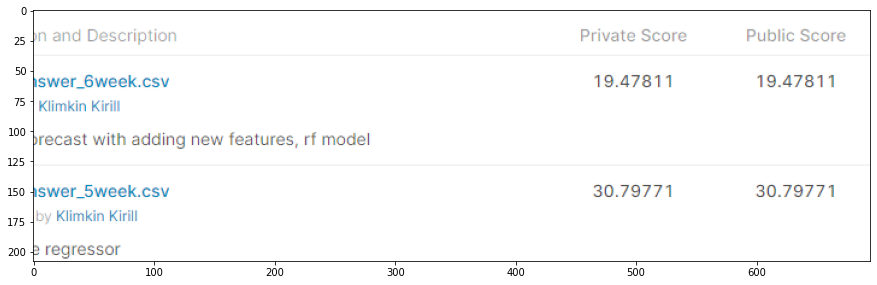

In [36]:
img = plt.imread('answer_week6.png')
plt.figure(figsize=(15,7))
plt.imshow(img)
plt.show()